In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import shutil
import json
import random
from pathlib import Path
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, Dropout,GlobalAveragePooling2D, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
base_dir = "F:\Desktop\project"
train_dir = os.path.join(base_dir,"dataset" ,"train")
test_dir = os.path.join(base_dir,"dataset", "test")
val_dir = os.path.join(base_dir,"dataset",'validation')

combining 2 datasets

In [3]:
os.makedirs(os.path.join(train_dir, "cats"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "dogs"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "cats"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "dogs"), exist_ok=True)

In [13]:
os.makedirs(os.path.join(val_dir, "cats"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "dogs"), exist_ok=True)

In [ ]:
def copy_images(src_folder, dest_folder):
  for file in os.listdir(src_folder):
      if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        src_path = os.path.join(src_folder, file)
        dst_path = os.path.join(dest_folder, file)
        if os.path.isfile(src_path):
            os.system(f'cp "{src_path}" "{dst_path}"')

In [ ]:
def split_and_copy_images(src_folder, train_dir, test_dir,animal, split=0.8, seed=42):
    random.seed(seed)

    
    imgs = [f for f in os.listdir(src_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    random.shuffle(imgs)

     
    n = int(len(imgs) * split)
    train_imgs, test_imgs = imgs[:n], imgs[n:]

    
    def copy_list(file_list, dest_folder):
        os.makedirs(dest_folder, exist_ok=True)
        for fname in file_list:
            src = os.path.join(src_folder, fname)
            dst = os.path.join(dest_folder, fname)
            if os.path.isfile(src):
                shutil.copy2(src, dst)

    copy_list(train_imgs, os.path.join(train_dir, animal))
    copy_list(test_imgs,  os.path.join(test_dir, animal))

# usage
split_and_copy_images("F:\Desktop\project\Cat", train_dir, test_dir,"cats", split=0.8)
split_and_copy_images("F:\Desktop\project\Dog", train_dir, test_dir,"dogs", split=0.8)

In [ ]:
# add cifar
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def save_cifar_images(images, labels, folder):
    for i, (img, label) in enumerate(zip(images, labels.flatten())):
        if label == 3:  # cat
            path = os.path.join(folder, "cats", f"cifar_cat_{i}.png")
        elif label == 5:  # dog
            path = os.path.join(folder, "dogs", f"cifar_dog_{i}.png")
        else:
            continue
        cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

save_cifar_images(x_train, y_train, train_dir)
save_cifar_images(x_test, y_test, test_dir)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step


In [ ]:
def split_train_to_validation(train_root,
                              validation_root,
                              split: float = 0.15):



    for cls in ('cats', 'dogs'):
        # directories
        src_dir = train_root  / cls
        dst_dir = validation_root    / cls
        dst_dir.mkdir(parents=True, exist_ok=True)

        
        imgs = [f for f in src_dir.iterdir() if f.is_file()]
        n_move = int(len(imgs) * split)


        to_move = random.sample(imgs, n_move)

       
        for file in to_move:
            shutil.move(str(file), str(dst_dir / file.name))

        print(f'{cls:>5}: moved {n_move:4d} / {len(imgs):4d} '
              f'({n_move/len(imgs)*100:.1f}%)')

In [ ]:
split_train_to_validation(train_dir,val_dir)

In [ ]:
len(os.listdir("F:\\Desktop\\project\\dataset\\train\\cats"))

15000

In [ ]:
def is_valid_image(file_path):
    
    try:
        # Try to read and decode the image
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3)
        return True
    except:
        return False

def remove_corrupted_images(directory):
    
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                if not is_valid_image(file_path):
                    print(f"Removing corrupted file: {file_path}")
                    os.remove(file_path)


remove_corrupted_images(train_dir)
remove_corrupted_images(test_dir)

Removing corrupted file: F:\Desktop\project\dataset\train\cats\10404.jpg
Removing corrupted file: F:\Desktop\project\dataset\train\cats\666.jpg
Removing corrupted file: F:\Desktop\project\dataset\train\dogs\11702.jpg
Removing corrupted file: F:\Desktop\project\dataset\train\dogs\11912.jpg
Removing corrupted file: F:\Desktop\project\dataset\train\dogs\2317.jpg
Removing corrupted file: F:\Desktop\project\dataset\train\dogs\2494.jpg
Removing corrupted file: F:\Desktop\project\dataset\train\dogs\9500.jpg
Removing corrupted file: F:\Desktop\project\dataset\test\cats\4351.jpg
Removing corrupted file: F:\Desktop\project\dataset\test\dogs\11233.jpg


In [ ]:
len(os.listdir("F:\\Desktop\\project\\dataset\\train\\cats"))

14998

plot images

Total images found: 36991


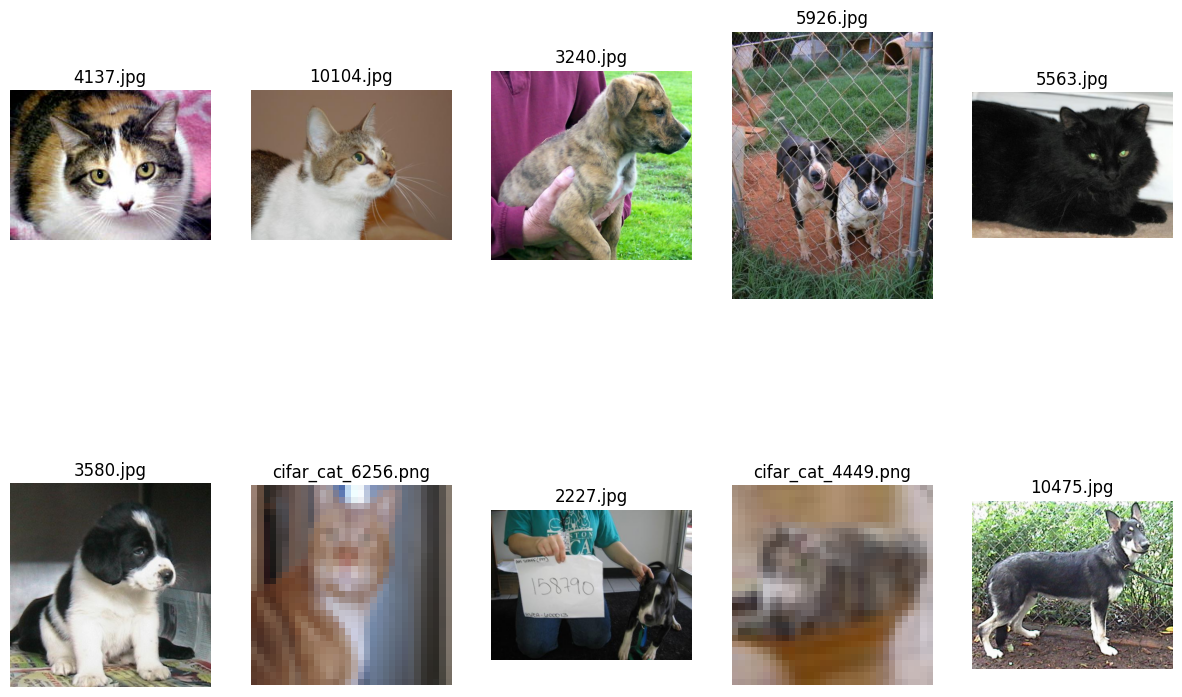

In [ ]:
base_dir = "/content/drive/MyDrive/combined_dataset"


all_images = []
for root, dirs, files in os.walk("F:\Desktop\project\dataset\tra"):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_images.append(os.path.join(root, file))

print(f"Total images found: {len(all_images)}")


sample_images = random.sample(all_images, 10)


plt.figure(figsize=(15, 10))
for i, img_path in enumerate(sample_images):
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i+1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
plt.show()


#preproccesing and optimizing data

optimize pipeline

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    batch_size=64,
    image_size=(32, 32),
    shuffle=True,
    seed=123
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='binary',
    batch_size=64,
    image_size=(32, 32),
    shuffle=False
)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    batch_size=64,
    image_size=(32, 32),
    shuffle=False
)

rescaling = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (rescaling(x), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset   = validation_dataset.map(lambda x, y: (rescaling(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(lambda x, y: (rescaling(x), y),
                       num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset   = validation_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.prefetch(tf.data.AUTOTUNE)



Found 25495 files belonging to 2 classes.
Found 4498 files belonging to 2 classes.
Found 6998 files belonging to 2 classes.


In [19]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [ ]:
def train_and_evaluate_model(model, train_dataset, test_dataset , validation_dataset,
                             epochs=30,model_name="Model", callbacks=None):

    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=1,
        shuffle = False
    )

    # Plot loss
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel("Binary Crossentropy Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(f"{model_name} Test Accuracy: {test_acc*100:.2f}%")

    return history, (test_loss, test_acc)

In [24]:
def report(model,model_name,model_history):
  best_val_acc = max(model_history.history["val_accuracy"])
  best_val_loss = min(model_history.history["val_loss"])
  best_train_acc = max(model_history.history["accuracy"])
  best_train_loss = min(model_history.history["loss"])


  results_model = {
    "best_train_accuracy": best_train_acc,
    "best_val_accuracy": best_val_acc,
    "best_train_loss": best_train_loss,
    "best_val_loss": best_val_loss,
    }
  
  filename = f"results_{model_name}.json"
  file_path = os.path.join(base_dir, filename)

  with open(file_path, 'w') as f:
    json.dump(results_model, f, indent=4)

  print(f"Results saved to: {os.path.abspath(file_path)}")
  return  results_model

In [28]:
def cr_and_cm(model,model_name, test_dataset):
    y_true = np.concatenate([labels.numpy() for _, labels in test_dataset], axis=0)

    y_pred_probs = model.predict(test_dataset, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    print(model_name)
    print("True labels shape:", y_true.shape)
    print("Predicted labels shape:", y_pred.shape)
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

cnn model


f:\Desktop\project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 132s 304ms/step - accuracy: 0.6008 - loss: 0.7320 - val_accuracy: 0.6679 - val_loss: 0.6031 - learning_rate: 0.0010
Epoch 2/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 117s 293ms/step - accuracy: 0.6930 - loss: 0.5879 - val_accuracy: 0.6721 - val_loss: 0.5899 - learning_rate: 0.0010
Epoch 3/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 118s 294ms/step - accuracy: 0.7503 - loss: 0.5053 - val_accuracy: 0.7554 - val_loss: 0.5177 - learning_rate: 0.0010
Epoch 4/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 116s 291ms/step - accuracy: 0.7838 - loss: 0.4596 - val_accuracy: 0.7777 - val_loss: 0.4707 - learning_rate: 0.0010
Epoch 5/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 116s 292ms/step - accuracy: 0.8007 - loss: 0.4292 - val_accuracy: 0.7901 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 6/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 117s 293ms/step - accuracy: 0.8142 - loss: 0.4033 - val_accuracy: 0.7550 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 7/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 117s 292ms/step - accura

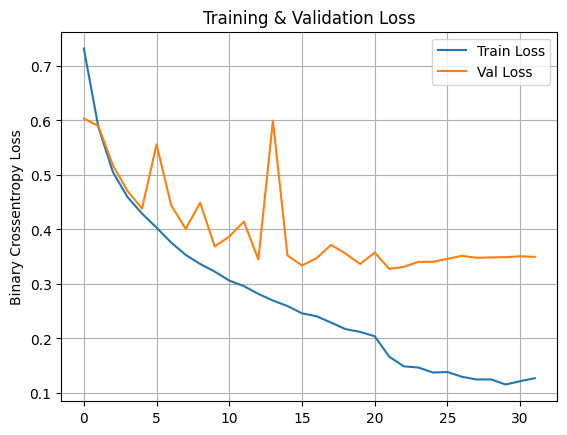

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.8742 - loss: 0.3330
CNN Test Accuracy: 87.42%


In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])




history_cnn = cnn_model.fit(train_dataset,
                        epochs=35,
                        validation_data=validation_dataset,
                        callbacks=callbacks)
# Plot loss
plt.plot(history_cnn.history['loss'], label="Train Loss")
plt.plot(history_cnn.history['val_loss'], label="Val Loss")
plt.title("Training & Validation Loss")
plt.ylabel("Binary Crossentropy Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate
test_loss, test_acc = cnn_model.evaluate(test_dataset)
print(f"CNN Test Accuracy: {test_acc*100:.2f}%")

In [22]:
cnn_model.save("F:\Desktop\project\models\cnn_combined_model.keras")

In [27]:
cnn_result = report(cnn_model,"cnn_combined_model",history_cnn)

Results saved to: F:\Desktop\project\results_cnn_combined_model.json


In [29]:
cr_and_cm(cnn_model,"cnn_combined_model", test_dataset)

cnn_combined_model
True labels shape: (6998, 1)
Predicted labels shape: (6998,)

Confusion Matrix:
[[3006  493]
 [ 387 3112]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87      3499
         1.0       0.86      0.89      0.88      3499

    accuracy                           0.87      6998
   macro avg       0.87      0.87      0.87      6998
weighted avg       0.87      0.87      0.87      6998



vgg16 model

In [ ]:
print(Path.home())

C:\Users\Maryam


In [30]:
weights_path = r'F:\Desktop\project\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def build_vgg16(input_shape=(32, 32, 3)):
    
    base_model = VGG16(weights=weights_path, include_top=False, input_shape=input_shape)

    
    for layer in base_model.layers:
        layer.trainable = False

    
    inputs = Input(shape=(32,32,3))
    x = RandomFlip("horizontal")(inputs)
    x = RandomRotation(0.1)(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

vgg16_model = build_vgg16()

Epoch 1/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 187s 462ms/step - accuracy: 0.5686 - loss: 5.5066 - val_accuracy: 0.6596 - val_loss: 2.0169 - learning_rate: 1.0000e-04
Epoch 2/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 196s 491ms/step - accuracy: 0.6011 - loss: 3.0332 - val_accuracy: 0.6587 - val_loss: 1.3968 - learning_rate: 1.0000e-04
Epoch 3/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 201s 505ms/step - accuracy: 0.6149 - loss: 1.8534 - val_accuracy: 0.6641 - val_loss: 1.0543 - learning_rate: 1.0000e-04
Epoch 4/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 200s 500ms/step - accuracy: 0.6223 - loss: 1.2653 - val_accuracy: 0.6625 - val_loss: 0.8514 - learning_rate: 1.0000e-04
Epoch 5/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 200s 499ms/step - accuracy: 0.6214 - loss: 0.9843 - val_accuracy: 0.6716 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 6/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 203s 508ms/step - accuracy: 0.6303 - loss: 0.8620 - val_accuracy: 0.6710 - val_loss: 0.7298 - learning_rate: 1.0000e-05
Epoch 7/35
399/399 ━━━━━━━━━━━━━━━━━━━━ 

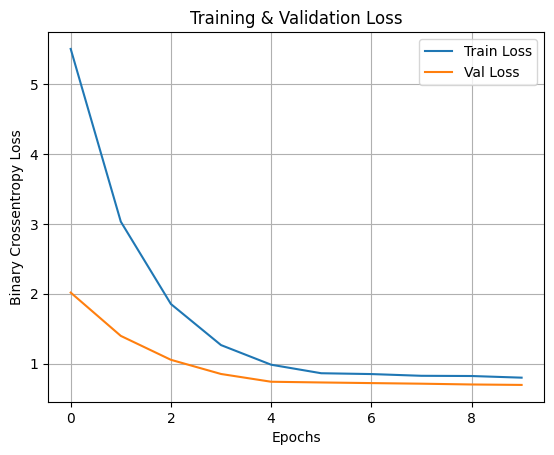

vgg16_Model Test Accuracy: 66.63%


In [32]:
vgg16_history,vgg16_test_results = train_and_evaluate_model(vgg16_model, train_dataset, test_dataset , validation_dataset,
                             epochs=35, model_name="vgg16_Model",
                            callbacks=callbacks)


In [37]:
vgg16_model.save(r"F:\Desktop\project\models\vgg_combined_model.keras")

In [34]:
vgg_result = report(vgg16_model,"vgg16_combined_model",vgg16_history)

Results saved to: F:\Desktop\project\results_vgg16_combined_model.json


In [35]:
cr_and_cm(vgg16_model,"vgg16_combined_model", test_dataset)

vgg16_combined_model
True labels shape: (6998, 1)
Predicted labels shape: (6998,)

Confusion Matrix:
[[2133 1366]
 [ 969 2530]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65      3499
         1.0       0.65      0.72      0.68      3499

    accuracy                           0.67      6998
   macro avg       0.67      0.67      0.67      6998
weighted avg       0.67      0.67      0.67      6998

